In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.optim as optim

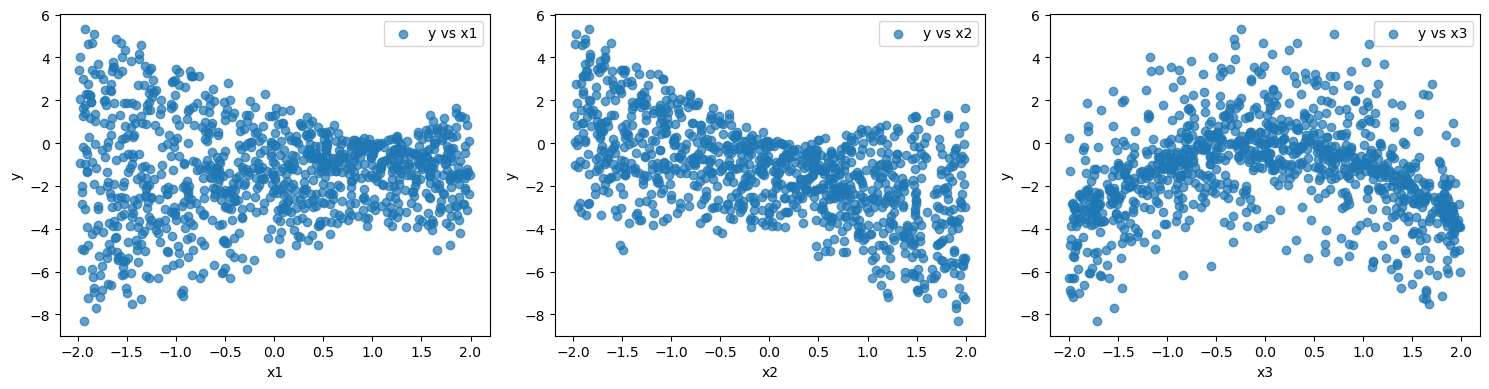

In [259]:
# Generate toy data
np.random.seed(42)  # For reproducibility

# Number of samples
n_samples = 1000

# Generate input data
x1 = np.random.uniform(-2, 2, n_samples)
x2 = np.random.uniform(-2, 2, n_samples)
x3 = np.random.uniform(-2, 2, n_samples)

# Stack inputs into a single matrix
X = np.column_stack((x1, x2, x3))

# Generate output data
#y = x1*x2 + np.sin(np.pi*2*x2) + np.exp(x1) + x3**2 - x3**4  + 0.1 * np.random.randn(n_samples)

y = x1*x2 - x3**2 - x2 + 0.1 * np.random.randn(n_samples)


# Visualize the relationships with y
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(["x1", "x2", "x3"]):
    axs[i].scatter(X[:, i], y, alpha=0.7, label=f"y vs {feature}")
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("y")
    axs[i].legend()

plt.tight_layout()
plt.show()



In [260]:

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100/n_samples, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test= torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to match model output
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1) 

In [582]:
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset from X_train and y_train
train_dataset = TensorDataset(X_train, y_train)

# Create a DataLoader with a specified batch size
batch_size = 64  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [2]:
activation = nn.Sigmoid()  # ReLU activation function

class BranchingNetwork(nn.Module):
    def __init__(self):
        super(BranchingNetwork, self).__init__()
        
        # First hidden layer (3 nodes)
        self.fc1 = nn.Linear(3, 3)
        
        # Define the 9 branches (3x3 connections)
        self.branches = nn.ModuleList([
            nn.Linear(1, 1, bias=False) for _ in range(9)  # No bias for individual branches
        ])
        
        # Bias for the second hidden layer (3 nodes)
        self.bias_h2 = nn.Parameter(torch.zeros(3))
        
        # Third hidden layer (3 nodes)
        self.fc3 = nn.Linear(3, 3)
        
        # Output layer
        self.output = nn.Linear(3, 1)
    
    def forward(self, x):
        # First hidden layer
        h1 = self.fc1(x)
        h1 = activation(h1)

        # Pass through each branch
        h2 = torch.zeros(x.shape[0], 3, device=x.device)
        for i in range(3):  # For each node in the first hidden layer
            for j in range(3):  # For each node in the second hidden layer
                # Apply the corresponding branch
                branch_output = self.branches[i * 3 + j](h1[:, i].unsqueeze(1))
                h2[:, j] += branch_output.squeeze(1)

        # Add bias to the second hidden layer
        h2 += self.bias_h2

        # Apply ReLU activation
        h2 = activation(h2)

        # Third hidden layer
        h3 = self.fc3(h2)
        h3 = activation(h3)
        
        # Output layer
        out = self.output(h3)
        return out

# Example usage
model = BranchingNetwork()

In [3]:
# Initialize counters
weight_count = 0
bias_count = 0

# Iterate through the model's parameters
for name, param in model.named_parameters():
    if 'weight' in name:
        weight_count += param.numel()  # numel() returns the number of elements in the tensor
    elif 'bias' in name:
        bias_count += param.numel()

print(f"Total number of weights: {weight_count}")
print(f"Total number of biases: {bias_count}")

Total number of weights: 30
Total number of biases: 10


In [811]:
# Assuming `model` is your neural network model
with torch.no_grad():
    # Set the weights of the two largest branches
    model.branches[largest_two[0][0]].weight.fill_(largest_two[0][1])
    model.branches[largest_two[1][0]].weight.fill_(largest_two[1][1])


for param in model.parameters():
    param.requires_grad = True

In [812]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [813]:
# Training loop
n_epochs = 1000
best_loss = np.inf

for epoch in range(n_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Track loss for the epoch
    
    for batch in train_loader:  # Iterate over batches
        X_batch, y_batch = batch  # Unpack the batch
        
        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for this epoch
        epoch_loss += loss.item()
    
    # Calculate average loss for this epoch
    epoch_loss /= len(train_loader)
    
    # Print loss every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")


Epoch 50/1000, Loss: 1.8821
Epoch 100/1000, Loss: 0.6610
Epoch 150/1000, Loss: 0.5159
Epoch 200/1000, Loss: 0.5097
Epoch 250/1000, Loss: 0.4996
Epoch 300/1000, Loss: 0.5124
Epoch 350/1000, Loss: 0.4304
Epoch 400/1000, Loss: 0.4077
Epoch 450/1000, Loss: 0.3825
Epoch 500/1000, Loss: 0.3708
Epoch 550/1000, Loss: 0.3580
Epoch 600/1000, Loss: 0.3580
Epoch 650/1000, Loss: 0.3487
Epoch 700/1000, Loss: 0.3307
Epoch 750/1000, Loss: 0.3314
Epoch 800/1000, Loss: 0.3336
Epoch 850/1000, Loss: 0.3299
Epoch 900/1000, Loss: 0.3504
Epoch 950/1000, Loss: 0.3451
Epoch 1000/1000, Loss: 0.3167
Test Loss: 0.3698


In [569]:

# Function to randomize the two branches with the largest weight and freeze others
def find_largest_two_and_freeze_rest(model):
    # Get the absolute values of all branch weights
    branch_weights = [
        (idx, branch.weight.item()) for idx, branch in enumerate(model.branches)
    ]
    
    # Find the two branches with the largest weights
    branch_weights_sorted = sorted(branch_weights, key=lambda x: abs(x[1]), reverse=True)
    largest_two = branch_weights_sorted[:2]
    largest_two = sorted(largest_two, key=lambda x: x[0])

    
    print("Branches with largest weights:", largest_two)

    
    # Freeze all weights except the two largest branches
    for idx, branch in enumerate(model.branches):
        for param in branch.parameters():
            param.requires_grad = idx in [branch[0] for branch in largest_two]

    # Freeze all other parts of the model
    for name, param in model.named_parameters():
        if not name.startswith("branches"):
            param.requires_grad = False



    return largest_two

# Randomize the largest weights and freeze the rest
largest_two = find_largest_two_and_freeze_rest(model)




Branches with largest weights: [(0, 6.9169087409973145), (7, -7.82094144821167)]


In [814]:
import random

# Function to randomize two branch weights and freeze all others
def find_two_random_and_freeze_rest(model):
    
    branch_weights = [
        (idx, branch.weight.item()) for idx, branch in enumerate(model.branches)
    ]

    random_two= random.sample(branch_weights, 2)
    random_two = sorted(random_two)  # Sort for consistency in output

    print("Randomly selected branches:", random_two)

    #random_two = branch_weights[random_two_indx[0]], branch_weights[random_two_indx[1]]

     # Freeze all weights except the two largest branches
    for idx, branch in enumerate(model.branches):
        for param in branch.parameters():
            param.requires_grad = idx in [branch[0] for branch in random_two]

    # Freeze all other parts of the model
    for name, param in model.named_parameters():
        if not name.startswith("branches"):
            param.requires_grad = False
            
    return random_two

# Example usage
random_two = find_two_random_and_freeze_rest(model)

largest_two = random_two


Randomly selected branches: [(3, -1.733431100845337), (7, 0.22939692437648773)]


In [394]:
import random

# Function to randomize two branch weights and freeze all others
def find_two_random_and_freeze_rest(model):
    
    branch_weights = [
        (idx, branch.weight.item()) for idx, branch in enumerate(model.branches)
    ]

    random_two= [branch_weights[5], branch_weights[8]]

    print("Randomly selected branches:", random_two)

    #random_two = branch_weights[random_two_indx[0]], branch_weights[random_two_indx[1]]

     # Freeze all weights except the two largest branches
    for idx, branch in enumerate(model.branches):
        for param in branch.parameters():
            param.requires_grad = idx in [branch[0] for branch in random_two]

    # Freeze all other parts of the model
    for name, param in model.named_parameters():
        if not name.startswith("branches"):
            param.requires_grad = False
            
    return random_two

# Example usage
random_two = find_two_random_and_freeze_rest(model)

largest_two = random_two


Randomly selected branches: [(5, 39.15375900268555), (8, 39.327850341796875)]


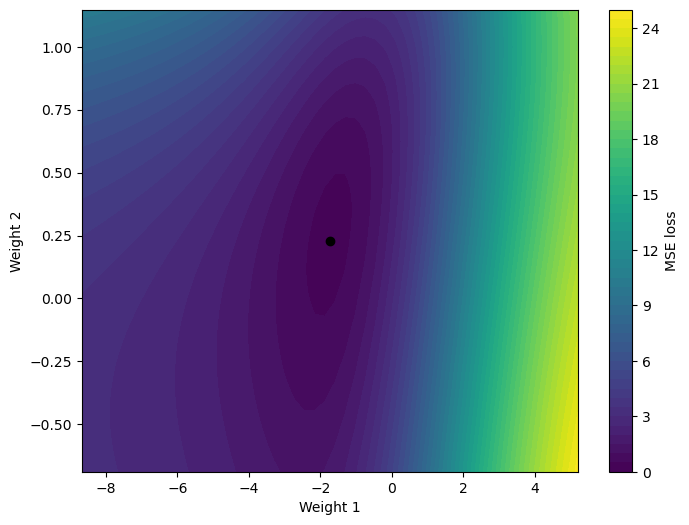

In [815]:


x1 = np.linspace(largest_two[0][1]-abs(largest_two[0][1])*4, largest_two[0][1]+abs(largest_two[0][1])*4, 50)  # Adjust the range as needed
x2 = np.linspace(largest_two[1][1]-abs(largest_two[1][1])*4, largest_two[1][1]+abs(largest_two[1][1])*4, 50)  # Adjust the range as needed
X1, X2 = np.meshgrid(x1, x2)
X3 = np.zeros_like(X1)  # To store results for the grid



# Iterate over the grid of values
for i in range(len(x1)):
    for j in range(len(x2)):
        with torch.no_grad():
            # Set the weights of the two largest branches
            model.branches[largest_two[0][0]].weight.fill_(x1[i])
            model.branches[largest_two[1][0]].weight.fill_(x2[j])
        
        # Perform a forward pass with the model (e.g., using dummy input)
        y_pred = model(X_train)
        
        # Use the output to populate the Z matrix
        X3[j, i] = criterion(y_pred, y_train).item()  # Normalize by the number of samples


# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, X3, levels=50, cmap="viridis")

plt.colorbar(label="MSE loss")
plt.scatter([largest_two[0][1]], [largest_two[1][1]], color="black", label="Optimal Weights")
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")
#plt.title("Output Landscape for two random weights")
plt.show()


In [895]:
def train_two_weights(optimizer, start_loc,  n_epochs = 100):
    with torch.no_grad():
        # Set the weights of the two largest branches
        model.branches[largest_two[0][0]].weight.fill_(start_loc[0])
        model.branches[largest_two[1][0]].weight.fill_(start_loc[1])

    # Retrain the network
    weights_history = []
    best_new_loss = np.inf
    for epoch in range(n_epochs):
        epoch_loss = 0.0  # Track loss for the epoch
        
        
        for batch in train_loader:  # Iterate over batches
            
            weights = [model.branches[idx].weight.item() for idx, _ in largest_two]
            weights_history.append(weights)
            
            X_batch, y_batch = batch  # Unpack the batch
            
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print gradients
            # print(model.branches[largest_two[0][0]].weight.grad)
            # print(model.branches[largest_two[1][0]].weight.grad)
            # break
            
            # Accumulate loss for this epoch
            epoch_loss += loss.item()
            # print(np.linalg.norm(np.array(weights) - np.array([largest_two[0][1], largest_two[1][1]])))
            # print(np.array(weights))
            if np.linalg.norm(np.array(weights) - np.array([largest_two[0][1], largest_two[1][1]])) < 1e-1:
                
                weights_history = np.array(weights_history)
                return weights_history, best_new_loss, epoch

        epoch_loss /= len(train_loader)
        
        if epoch_loss < best_new_loss:
            best_new_loss = epoch_loss
        

    # Convert weights_history to a numpy array if it's not already
    weights_history = np.array(weights_history)


    return weights_history, best_new_loss, None

In [903]:
# Define a loss function and optimizer for training
# Create a DataLoader with a specified batch size
batch_size = 1  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
learning_rate = 0.1


criterion = nn.MSELoss()
#start_loc = [largest_two[0][1]-10, largest_two[1][1]-10]
start_loc = [2, -8]

n_epochs = 1


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
Adam_journey, Adam_loss, Adam_n_iterations = train_two_weights(optimizer, start_loc=start_loc, n_epochs=n_epochs)
print(Adam_loss)



optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
SGD_journey, SGD_loss, SGD_n_iterations = train_two_weights(optimizer, start_loc=start_loc, n_epochs=n_epochs)
print(SGD_loss)

# optimizer = optim.Adagrad(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
# Adagrad_journey, Adagrad_loss, Adagrad_n_iterations = train_two_weights(optimizer, start_loc=start_loc, n_epochs=n_epochs)
# print(Adagrad_loss)

optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
RMSprop_journey, RMSprop_loss, RMSprop_n_iterations = train_two_weights(optimizer, start_loc=start_loc, n_epochs=n_epochs)
print(RMSprop_loss)

inf
4.793652780193806
inf


In [904]:
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
AdamW_journey, AdamW_loss, AdamW_n_iterations = train_two_weights(optimizer, start_loc=start_loc, n_epochs=n_epochs)
print(AdamW_loss)

inf


In [905]:

def extract_min_max(journeys):
    min_x = min_y = np.inf
    max_x = max_y = -np.inf
    for journey in journeys:
        min_x = min(min_x, journey[:, 0].min())
        min_y = min(min_y, journey[:, 1].min())
        max_x = max(max_x, journey[:, 0].max())
        max_y = max(max_y, journey[:, 1].max())

    min_x = min(min_x, start_loc[0])
    min_y = min(min_y, start_loc[1])
    max_x = max(max_x, start_loc[0])
    max_y = max(max_y, start_loc[1])

    min_x = min(min_x, largest_two[0][1])
    min_y = min(min_y, largest_two[1][1])
    max_x = max(max_x, largest_two[0][1])
    max_y = max(max_y, largest_two[1][1])

    return min_x, min_y, max_x, max_y   


journeys = [AdamW_journey, Adam_journey, RMSprop_journey, SGD_journey]
min_x, min_y, max_x, max_y = extract_min_max(journeys)

print(min_x, min_y, max_x, max_y)

-6.902252197265625 -8.0 2.0 0.45169711112976074


In [906]:
x = np.linspace(min_x-3, max_x+3, 50)  
y = np.linspace(min_y-3, max_y+1, 50)  
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)  # To store results for the grid

# Iterate over the grid of values
for i in range(len(x)):
    for j in range(len(y)):
        with torch.no_grad():
            # Set the weights of the two largest branches
            model.branches[largest_two[0][0]].weight.fill_(x[i])
            model.branches[largest_two[1][0]].weight.fill_(y[j])
        
        # Perform a forward pass with the model (e.g., using dummy input)
        y_pred = model(X_train)
        
        # Use the output to populate the Z matrix
        Z[j, i] = criterion(y_pred, y_train).item() 


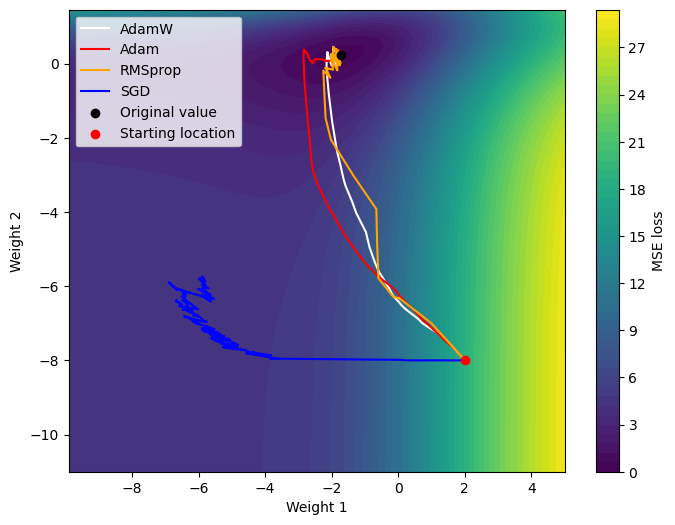

Original loss: 0.2991294284661611
Adam loss: inf, after 0 iterations
SGD loss: 4.7937, after None iterations
Adagrad loss: 26.0803, after None iterations
RMSprop loss: inf, after 0 iterations
AdamW loss: inf, after 0 iterations


In [907]:
plt.figure(figsize=(8, 6))
plt.plot(  AdamW_journey[:, 0],   AdamW_journey[:,1], color="white", label="AdamW")
plt.plot(   Adam_journey[:, 0],    Adam_journey[:,1], color="red", label="Adam")
plt.plot(RMSprop_journey[:, 0], RMSprop_journey[:,1], color="orange", label="RMSprop") 
#plt.plot(Adagrad_journey[:, 0], Adagrad_journey[:,1], color="green", label="Adagrad")
plt.plot(    SGD_journey[:, 0],     SGD_journey[:,1], color="blue", label="SGD")
plt.scatter([largest_two[0][1]], [largest_two[1][1]], color="black", label="Original value", zorder=5) 
plt.scatter([start_loc[0]], [start_loc[1]], color="red", label="Starting location", zorder=5)

plt.contourf(X, Y, Z, levels=50, cmap="viridis")

plt.colorbar(label="MSE loss")
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")
#plt.title("Output landscape for largest two weights between the first and second hidden layer")
plt.legend(loc = 'upper left')
plt.show()

print('Original loss:', best_loss)
print(f'Adam loss: {Adam_loss:.4f}, after {Adam_n_iterations} iterations')
print(f'SGD loss: {SGD_loss:.4f}, after {SGD_n_iterations} iterations')
print(f'Adagrad loss: {Adagrad_loss:.4f}, after {Adagrad_n_iterations} iterations')
print(f'RMSprop loss: {RMSprop_loss:.4f}, after {RMSprop_n_iterations} iterations')
print(f'AdamW loss: {AdamW_loss:.4f}, after {AdamW_n_iterations} iterations')



(-9.902252197265625, 5.0, -11.0, 1.4516971111297607)

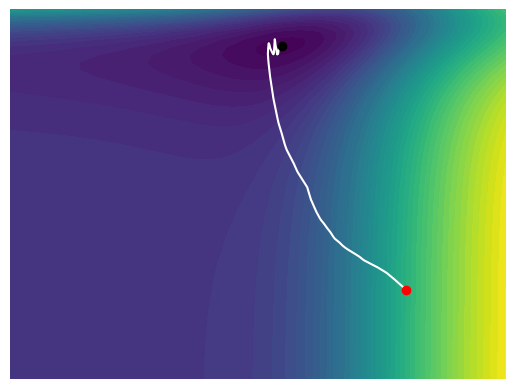

In [911]:
plt.contourf(X, Y, Z, levels=50, cmap="viridis")
plt.plot(  AdamW_journey[:, 0],   AdamW_journey[:,1], color="white", label="AdamW")
plt.scatter([start_loc[0]], [start_loc[1]], color="red", label="Starting location", zorder=5)
plt.scatter([largest_two[0][1]], [largest_two[1][1]], color="black", label="Original value", zorder=5) 

plt.axis('off')

In [901]:
x = np.linspace(largest_two[0][1]-1, largest_two[0][1]+1, 50)  # x?
y = np.linspace(largest_two[1][1]-1, largest_two[1][1]+1, 50)  # x?
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)  # To store results for the grid

# Iterate over the grid of values
for i in range(len(x)):
    for j in range(len(y)):
        with torch.no_grad():
            # Set the weights of the two largest branches
            model.branches[largest_two[0][0]].weight.fill_(x[i])
            model.branches[largest_two[1][0]].weight.fill_(y[j])
        
        # Perform a forward pass with the model (e.g., using dummy input)
        y_pred = model(X_train)
        
        # Use the output to populate the Z matrix
        Z[j, i] = criterion(y_pred, y_train).item()  # Average loss


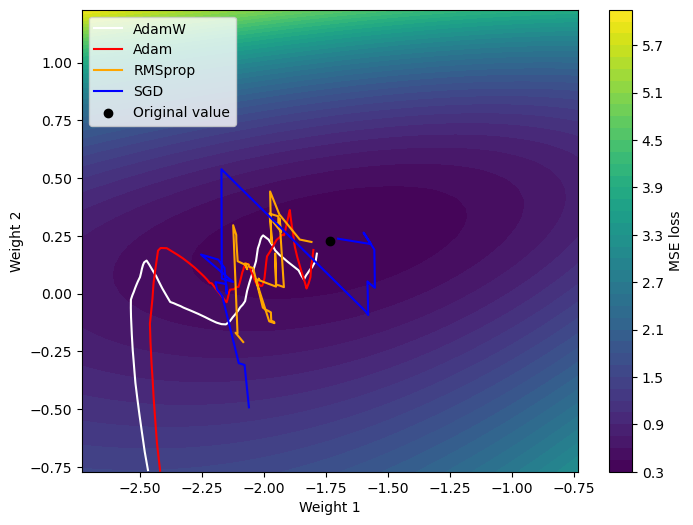

In [902]:
# Define the boundaries of the contour plot
x_min, x_max = X.min(), X.max()
y_min, y_max = Y.min(), Y.max()

# Function to filter journey points inside the contour plot boundaries
def filter_journey(journey):
    return journey[(journey[:, 0] >= x_min) & (journey[:, 0] <= x_max) & (journey[:, 1] >= y_min) & (journey[:, 1] <= y_max)]

# Filter journeys
filtered_AdamW_journey = filter_journey(AdamW_journey)
filtered_Adam_journey = filter_journey(Adam_journey)
filtered_RMSprop_journey = filter_journey(RMSprop_journey)
filtered_SGD_journey = filter_journey(SGD_journey)

# Plot the filtered journeys
plt.figure(figsize=(8, 6))
plt.plot(filtered_AdamW_journey[:, 0], filtered_AdamW_journey[:, 1], color="white", label="AdamW")
plt.plot(filtered_Adam_journey[:, 0], filtered_Adam_journey[:, 1], color="red", label="Adam")
plt.plot(filtered_RMSprop_journey[:, 0], filtered_RMSprop_journey[:, 1], color="orange", label="RMSprop")
plt.plot(filtered_SGD_journey[:, 0], filtered_SGD_journey[:, 1], color="blue", label="SGD")
plt.scatter([largest_two[0][1]], [largest_two[1][1]], color="black", label="Original value", zorder=5)
#plt.scatter([start_loc[0]], [start_loc[1]], color="red", label="Randomized starting location", zorder=5)

plt.contourf(X, Y, Z, levels=50, cmap="viridis")

plt.colorbar(label="MSE loss")
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")
#plt.title("Output landscape for largest two weights between the first and second hidden layer")
plt.legend(loc='upper left')
plt.show()

In [836]:
print(X1)
print('-----------------')
print(X)

[[-8.6671555  -8.38414634 -8.10113719 ...  4.63427498  4.91728414
   5.2002933 ]
 [-8.6671555  -8.38414634 -8.10113719 ...  4.63427498  4.91728414
   5.2002933 ]
 [-8.6671555  -8.38414634 -8.10113719 ...  4.63427498  4.91728414
   5.2002933 ]
 ...
 [-8.6671555  -8.38414634 -8.10113719 ...  4.63427498  4.91728414
   5.2002933 ]
 [-8.6671555  -8.38414634 -8.10113719 ...  4.63427498  4.91728414
   5.2002933 ]
 [-8.6671555  -8.38414634 -8.10113719 ...  4.63427498  4.91728414
   5.2002933 ]]
-----------------
[[-2.7334311  -2.69261477 -2.65179845 ... -0.81506375 -0.77424743
  -0.7334311 ]
 [-2.7334311  -2.69261477 -2.65179845 ... -0.81506375 -0.77424743
  -0.7334311 ]
 [-2.7334311  -2.69261477 -2.65179845 ... -0.81506375 -0.77424743
  -0.7334311 ]
 ...
 [-2.7334311  -2.69261477 -2.65179845 ... -0.81506375 -0.77424743
  -0.7334311 ]
 [-2.7334311  -2.69261477 -2.65179845 ... -0.81506375 -0.77424743
  -0.7334311 ]
 [-2.7334311  -2.69261477 -2.65179845 ... -0.81506375 -0.77424743
  -0.7334311 ]